In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# toy example: you left the house and realise you don't have your keys. where are they?
# this is the most naive an inefficient text adventure on purpose.

#world = [('description', reward, [nested_world])]
class find_the_keys():
    "A little test world to get going"
    def __init__(self):
        self.world = (
            'look around', 0, [
                ('go left', 0, [
                    ('climb tree', 0, []),
                    ('search floor', 0, [
                        ('lift stone', 0,[]),
                        ('lift leaf', 0,[])
                    ])
                ]),
                ('go straight', 0, [
                    ('enter house', 0, [
                        ('check cupboard', 1, []),
                        ('check wardrobe', 0, [])
                    ])
                ]),
                ('go right', 0, [
                    ('check bike', 0, []), # bike is locked
                    ('check mailbox', 0, [
                        ('open first letter', 0, []),
                        ('open second letter', 0, []),
                        ('open third letter', 0, []),
                    ])
                ])
            ]
        )
        self.reset()
        
        
    def _get_state(self):
        state = self.world
        description = state[0]
        reward = state[1]
        actions = state[2]
        # go through all previous states to current one
        for a in self.previous_actions:
            description, reward, actions = actions[a]
        return description, reward, actions
    
    def _set_state(self, previous_actions):
        self.previous_actions = previous_actions
        self.description, self.reward, self.actions = self._get_state()
        
    def reset(self):
        self._set_state([])
    
    def get_description(self):
        return self.description
    
    def get_reward(self):
        return self.reward
    
    def _get_actions_and_rewards(self):
        return [(a[0], a[1]) for a in self.actions] + [('go back', 0)]
    
    def get_actions(self):
        return [a[0] for a in self.actions] + ['go back']

    def do(self, action):
        if action == 'go back':
            self._set_state(self.previous_actions[:-1])
            return "done"
        else:
            for i, a in enumerate(game._get_actions_and_rewards()):
                if a[0] == action:
                    self._set_state(self.previous_actions + [i])
                    return "done"
        return "impossible"

In [3]:
game = find_the_keys()

In [4]:
game._get_state()

('look around',
 0,
 [('go left',
   0,
   [('climb tree', 0, []),
    ('search floor', 0, [('lift stone', 0, []), ('lift leaf', 0, [])])]),
  ('go straight',
   0,
   [('enter house',
     0,
     [('check cupboard', 1, []), ('check wardrobe', 0, [])])]),
  ('go right',
   0,
   [('check bike', 0, []),
    ('check mailbox',
     0,
     [('open first letter', 0, []),
      ('open second letter', 0, []),
      ('open third letter', 0, [])])])])

In [5]:
game.get_description()

'look around'

In [6]:
game.get_reward()

0

In [7]:
game.get_actions()

['go left', 'go straight', 'go right', 'go back']

In [8]:
game.do('go left')

'done'

In [9]:
game.get_actions()

['climb tree', 'search floor', 'go back']

In [10]:
game.do('go back')

'done'

In [11]:
game.get_actions()

['go left', 'go straight', 'go right', 'go back']

In [12]:
# how to solve
game.do('go straight')
game.do('enter house')
game.do('check cupboard')
print(game.reward)

1


In [13]:
# random exploration
game = find_the_keys()
steps = 900
rewards_random = []
rng = np.random.default_rng()
for i in range(steps):
    description = game.get_description()
    actions = game.get_actions()
    rewards_random.append(game.get_reward())
    #print(description, reward)
    if rewards_random[-1]:
        # this only makes sense because of the specific game here
        #print("You won! Reseting game.")
        game._set_state([])
    else:
        j = rng.integers(0, len(actions))
        #print("do", actions[j][0])
        game.do(actions[j])

In [14]:
sum(rewards_random)

17

In [15]:
# q-learning
# again the most naive way I could think of, see https://en.wikipedia.org/wiki/Q-learning
class q_learner():
    """Naive q-learning agent
    
    Implementing reward table "q[state,action]" as a key-value map
    """
    def __init__(
        self,
        q_init:float = 1, # initial q > 0 incentivises exploration
        learning_rate:float = .9, # "alpha"
        discount_factor:float = .1, # "gamma"
        p_explore:float = 0.01,
        rng:np.random.Generator = np.random.default_rng() # allows to control randomness
    ):
        self.q = {} # the reward "table"
        self.q_init = q_init
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.p_explore = p_explore
        self.rng = rng
        self.verbose = False
    
    def get_q_s(self,state:str, actions:list):
        q_s = self.q.get(state, {})
        q_s = {a: self.q_init for a in actions} | q_s # fill q for missing actions
        return q_s
    
    def choose_action(self, state, actions):
        "explore or choose action maximising q. returns action & q"
        q_s = self.get_q_s(state, actions)
        if self.p_explore > self.rng.uniform():
            if self.verbose: print("explore")
            j = self.rng.integers(0, len(actions))
            action = actions[j]
        else:
            if self.verbose: print("exploit")
            if self.verbose: print(q_s)
            action = max(q_s, key=q_s.get)
        return action, q_s[action]
    
    def learn(self, state, action, action_q, new_state, new_state_q, new_actions):
        max_new_q = max(agent.get_q_s(new_state, new_actions).values())
        if verbose: print("q_sa", action_q)
        new_action_q = (
            (1 - self.learning_rate) * action_q
            + self.learning_rate * (new_state_q + self.discount_factor * max_new_q)
        )
        if state in self.q:
            self.q[state].update({action: new_action_q})
        else:
            self.q[state] = {action: new_action_q}
        if verbose: print(f"new q", self.q)


agent = q_learner()
game = find_the_keys()

state = game.get_description()
actions = game.get_actions()

steps = 900
rewards_q = []
verbose=False
agent.verbose=verbose

for i in range(steps):
    if verbose: print()
    if verbose: print("step", i, "state", state)
    
    action, action_q = agent.choose_action(state, actions)
    
    if verbose: print("do", action)
    game.do(action)
    
    new_state = game.get_description()
    new_reward = game.get_reward()
    new_actions = game.get_actions()
    
    #if verbose: print("new reward", new_reward, "max new q", max_new_q)
    
    #qsl = agent.get_q_s(state, [a for a in actions if a[0]==action])
    agent.learn(state, action, action_q, new_state, new_reward, new_actions)
    if verbose: print("q", agent.q)
    
    rewards_q.append(new_reward)
    
    # this particular game should be reset after the reward is found
    if new_reward:
        game.reset()
        new_state = game.get_description()
        new_actions = game.get_actions()
    
    # prepare for next iteration
    state = new_state
    actions = new_actions  

In [16]:
sum(rewards_q)

268

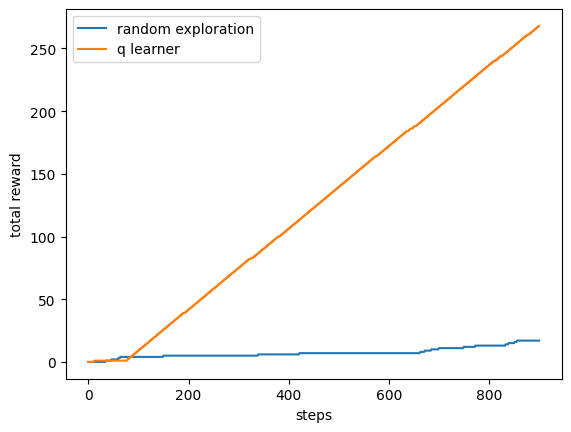

In [17]:
fig1 = plt.figure(num=1)
ax1 = fig1.gca()
ax1.plot(np.cumsum(rewards_random), label='random exploration')
ax1.plot(np.cumsum(rewards_q), label='q learner')
ax1.set_ylabel('total reward')
ax1.set_xlabel('steps')
ax1.legend()